# CPVT Patients Demographics

- Clinical features
  - Heart structure abnormalities
  - Exercise induced PVT
  - Exercise induced syncope
  - Exercise induced sudden cardiac arrest
  - Abnormal ECG at rest
- Patient sex
- Inheritance pattern
- Family history of sudden cardiac death

In [21]:
from typing import Callable

import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from dataclasses import dataclass

from analysis.database import get_config
from analysis.write_report import PdfSection

sns.set_style("ticks")

In [22]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_08"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [23]:
figure_3 = config.figure3

colors = config.figure_palette

figure_3.panels

{'panel_a': FigureParams(fig_size=None, title=None, xlabel=None, ylabel='Number of patients', xticklabels={False: 'Normal', True: 'Heart\nstructure\nabnormality'}, yticklabels=None, x_label_fontsize=10, y_label_fontsize=10, title_fontsize=10, x_tick_fontsize=8, y_tick_fontsize=8, panels=None),
 'panel_b': FigureParams(fig_size=None, title=None, xlabel=None, ylabel='Number of patients', xticklabels={False: 'No PVT', True: 'PVT'}, yticklabels=None, x_label_fontsize=10, y_label_fontsize=10, title_fontsize=10, x_tick_fontsize=8, y_tick_fontsize=8, panels=None),
 'panel_c': FigureParams(fig_size=None, title=None, xlabel=None, ylabel='Number of patients', xticklabels={False: 'No\nSyncope', True: 'Syncope'}, yticklabels=None, x_label_fontsize=10, y_label_fontsize=10, title_fontsize=10, x_tick_fontsize=8, y_tick_fontsize=8, panels=None),
 'panel_d': FigureParams(fig_size=None, title=None, xlabel=None, ylabel='Number of patients', xticklabels={False: 'No SCA', True: 'SCA'}, yticklabels=None, x_

In [24]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
# use this for individual data to prevent duplicates
df_cpvt_individuals = df_cpvt.drop_duplicates(subset="individual_id")
num_cpvt_patients = f"Number of CPVT patients: {df_cpvt_individuals.shape[0]}"

In [26]:
# number of unique variants
print(df_cpvt["sequence_variant_id"].nunique())
# number of protein HGVS strings (should be less since cdna will sometimes map to same amino acid)
df_cpvt["p_hgvs_string"].nunique()

281


272

In [27]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)


def add_bar_label(curr_ax: plt.Axes):
    for container in curr_ax.containers:
        curr_ax.bar_label(
            container,
            fmt="n=%g",
            fontsize=8,
        )


def remap_values(df_input: pd.DataFrame, column: str, mapping: dict, *,
                 num_total_samples: int, map_fn: Callable = None,
                 count_col: str = "count"):
    df_input[column] = df_input[column].apply(
        lambda x: mapping.get(map_fn(x), x) if map_fn else mapping.get(x, x)
    )
    df_input["percentage"] = df_input[count_col].apply(
        lambda x: x / num_total_samples * 100
    ).round(2)

    order_cats = list(mapping.values())
    palette = {
        x_axis: color for x_axis, color in
        zip(order_cats, sns.color_palette(colors.cat_palette, len(order_cats)))
    }

    return order_cats, palette


## Clinical features


In [28]:
df_cpvt_individuals["Heart Structure Abnormality"].value_counts()

Heart Structure Abnormality
0.0    447
1.0     44
Name: count, dtype: int64

,Heart Structure Abnormality,count,percentage
0,Normal,447,91.04
1,Heart\nstructure\nabnormality,44,8.96


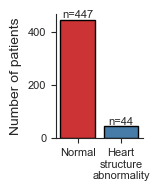

,Exercise/stress induced polymorphic ventricular tachycardia,count,percentage
0,PVT,315,98.13
1,No PVT,6,1.87


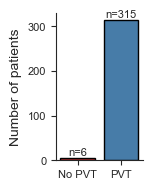

,Syncope exercise/stress induced,count,percentage
0,Syncope,261,96.67
1,No\nSyncope,9,3.33


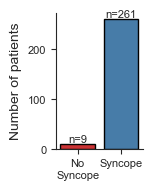

,Exercise/stress induced sudden cardiac arrest,count,percentage
0,SCA,97,85.84
1,No SCA,16,14.16


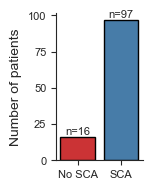

,Baseline/resting electrocardiogram abnormality,count,percentage
0,Normal\nECG\nat rest,387,83.59
1,Abnormal\nECG\nat rest,76,16.41


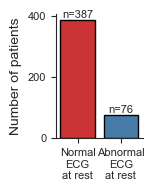

In [29]:
from matplotlib.figure import Figure
from analysis.database import set_figure_size


@dataclass
class Figure3Panel:
    column: str
    panel: str


@dataclass
class AxesInfo:
    panel: str
    plot: Figure


conditions_to_graph = [
    Figure3Panel(
        column="Heart Structure Abnormality",
        panel="panel_a",
    ),
    Figure3Panel(
        column="Exercise/stress induced polymorphic ventricular tachycardia",
        panel="panel_b",
    ),
    Figure3Panel(
        column="Syncope exercise/stress induced",
        panel="panel_c",
    ),
    Figure3Panel(
        column="Exercise/stress induced sudden cardiac arrest",
        panel="panel_d",
    ),
    Figure3Panel(
        column="Baseline/resting electrocardiogram abnormality",
        panel="panel_h",
    ),
]

axes_plotted: list[AxesInfo] = []
condition_info: list[PdfSection] = []

for fig_info in conditions_to_graph:
    figure_panel = figure_3.panels[fig_info.panel]
    condition = fig_info.column

    condition_info.append(
        PdfSection(
            section=figure_panel.title if figure_panel.title else condition,
            stuff=[]
        )
    )

    curr_info = condition_info[-1]

    # calculate the number of patients with the condition
    condition_data = df_cpvt_individuals[condition].value_counts().reset_index()
    total_patients = condition_data["count"].sum()
    order_plot, palette = remap_values(condition_data,
                                       condition,
                                       figure_panel.xticklabels,
                                       num_total_samples=total_patients,
                                       map_fn=bool
                                       )

    display(condition_data)

    # append stuff to add to the report
    curr_info.stuff.append(f"Total patients: {total_patients}")
    curr_info.stuff.append(condition_data)

    # plot the data
    curr_fig = plt.figure(figsize=figure_3.fig_size)
    sns.barplot(
        data=condition_data,
        x=condition,
        y="count",
        order=order_plot,
        hue=condition,
        legend=False,
        edgecolor="black",
        palette=palette,
        ax=curr_fig.gca()
    )

    add_bar_label(curr_fig.gca())

    set_figure_size(
        figure_panel,
        # x_tick_rotation=90,
    )

    axes_plotted.append(AxesInfo(panel=fig_info.panel, plot=curr_fig))

    save_current_plot(f"figure_3_{fig_info.panel}")

    plt.show()

## Sex

In [30]:
patient_sex = pd.DataFrame(
    df_cpvt_individuals["sex"].value_counts()).reset_index()
fig_e_cats, fig_e_palette = remap_values(
    patient_sex,
    "sex",
    figure_3.panels["panel_e"].xticklabels,
    num_total_samples=patient_sex["count"].sum()
)
patient_sex

,sex,count,percentage
0,Female,463,56.88
1,Male,351,43.12


In [31]:
df_cpvt_individuals["sex"].value_counts(dropna=False)

sex
female    463
male      351
NaN       150
Name: count, dtype: int64

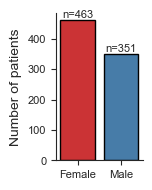

In [32]:
condition_info.append(PdfSection(
    section="Patient Sex",
    stuff=[
        f"Num total patients {patient_sex['count'].sum()}",
        patient_sex]
))

fig_e = plt.figure(figsize=figure_3.fig_size)

sns.barplot(
    data=patient_sex,
    x="sex",
    y="count",
    hue="sex",
    legend=False,
    edgecolor="black",
    palette=fig_e_palette,
    order=fig_e_cats,
    ax=fig_e.gca()
)
add_bar_label(fig_e.gca())
set_figure_size(
    figure_3.panels["panel_e"]
)

axes_plotted.append(AxesInfo(panel="panel_e", plot=fig_e))

save_current_plot("figure_3_panel_e")

plt.show()

## Inheritance

In [33]:
variant_inherit = pd.DataFrame(
    df_cpvt["inheritance"].value_counts()).reset_index()
fig_f_cats, fig_f_palette = remap_values(
    variant_inherit,
    "inheritance",
    figure_3.panels["panel_f"].xticklabels,
    num_total_samples=variant_inherit["count"].sum()
)
variant_inherit

,inheritance,count,percentage
0,Inherited,186,68.13
1,de novo,87,31.87


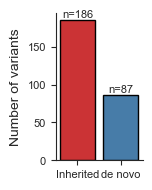

In [34]:
condition_info.append(PdfSection(
    section="Inheritance",
    stuff=[
        f"Num total variants {variant_inherit['count'].sum()}",
        variant_inherit
    ]
))

fig_f = plt.figure(figsize=figure_3.fig_size)

ax = sns.barplot(
    data=variant_inherit,
    x="inheritance",
    y="count",
    hue="inheritance",
    legend=False,
    edgecolor="black",
    palette=fig_f_palette,
    order=fig_f_cats,
)

add_bar_label(ax)
set_figure_size(
    figure_3.panels["panel_f"],

)

axes_plotted.append(AxesInfo(panel="panel_f", plot=fig_f))

save_current_plot("figure_3_panel_f")

plt.show()

## Family history of sudden cardiac death

In [35]:
bool(np.nan)

True

In [36]:
df_scd = df_cpvt_individuals[[
    "individual_id",
    "Sudden cardiac death::Mother",
    "Sudden cardiac death::Father",
    "Sudden cardiac death::num_family_members",
]].copy()
family_scd_col = "Family History of SCD"


def has_scd(row):
    if pd.isna(row["Sudden cardiac death::Mother"]) and pd.isna(
            row["Sudden cardiac death::Father"]) and pd.isna(
        row["Sudden cardiac death::num_family_members"]):
        return np.nan

    mother = row["Sudden cardiac death::Mother"] == 1
    father = row["Sudden cardiac death::Father"] == 1
    num_family_members = row["Sudden cardiac death::num_family_members"] > 0

    return mother or father or num_family_members


df_scd[family_scd_col] = df_scd.apply(
    has_scd,
    axis=1
)
df_scd.head()

,individual_id,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members,Family History of SCD
0,1,1.0,0.0,NaN,True
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,0.0,False
4,5,NaN,NaN,NaN,NaN


In [37]:
family_scd = pd.DataFrame(df_scd[family_scd_col].value_counts()).reset_index()

fig_g_cats, fig_g_palette = remap_values(
    family_scd,
    family_scd_col,
    figure_3.panels["panel_g"].xticklabels,
    num_total_samples=family_scd["count"].sum(),
    map_fn=bool
)
condition_info.append(PdfSection(
    section="Family History of SCD",
    stuff=[
        f"Num total patients {family_scd['count'].sum()}",
        family_scd,
    ]
))

family_scd

,Family History of SCD,count,percentage
0,Family\nhistory\nSCD,349,70.93
1,No family\nhistory\nSCD,143,29.07


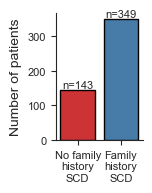

In [38]:
fig_g = plt.figure(figsize=figure_3.fig_size)
sns.set_style("ticks")
sns.barplot(
    data=family_scd,
    x="Family History of SCD",
    y="count",
    hue="Family History of SCD",
    legend=False,
    edgecolor="black",
    palette=fig_g_palette,
    order=fig_g_cats,
)

set_figure_size(
    figure_3.panels["panel_g"]
)

add_bar_label(fig_g.gca())
axes_plotted.append(AxesInfo(panel="panel_g", plot=fig_g))

save_current_plot("figure_3_panel_g")

plt.show()

In [39]:
from analysis.write_report import write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# report
pdf_name = figures_dir / "cpvt_demographics.pdf"

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, condition_info)
c.save()

print(f"PDF saved to {pdf_name}")

PDF saved to ../figures/0_3_1/analysis_08/cpvt_demographics.pdf
